# Introduction

This example demonstrates how to convert a network from [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) for use with Lasagne. We will be using the [NIN model](https://gist.github.com/mavenlin/e56253735ef32c3c296d) trained for CIFAR10.

We will create a set of Lasagne layers corresponding to the Caffe model specification (prototxt), then copy the parameters from the caffemodel file into our model.

# Final product
If you just want to try the final result, you can download the pickled weights [here](https://s3.amazonaws.com/lasagne/recipes/pretrained/cifar10/model.pkl)

# Converting from Caffe to Lasagne
### Download the required files

First we download `cifar10_nin.caffemodel` and `model.prototxt`. The supplied `train_val.prototxt` was modified to replace the data layers with an input specification, and remove the unneeded loss/accuracy layers.

In [1]:
!wget https://www.dropbox.com/s/blrajqirr1p31v0/cifar10_nin.caffemodel 
!wget https://gist.githubusercontent.com/ebenolson/91e2cfa51fdb58782c26/raw/b015b7403d87b21c6d2e00b7ec4c0880bbeb1f7e/model.prototxt

### Import Caffe

To load the saved parameters, we'll need to have Caffe's Python bindings installed.

In [2]:
import caffe

### Load the pretrained Caffe network

In [3]:
net_caffe = caffe.Net('model.prototxt', 'cifar10_nin.caffemodel', caffe.TEST)

### Import Lasagne

In [4]:
import lasagne
from lasagne.layers import InputLayer, DropoutLayer, FlattenLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.utils import floatX

### Define a custom pooling layer
To replicate Caffe's average pooling behavior, we need a custom layer derived from Lasagne's MaxPool2DLayer.

In [5]:
import theano
from theano.tensor.signal import downsample

# We need a recent theano version for this to work
assert theano.__version__ >= '0.7.0.dev-512c2c16ac1c7b91d2db3849d8e7f384b524d23b'

class AveragePool2DLayer(lasagne.layers.MaxPool2DLayer):
    def get_output_for(self, input, **kwargs):
        pooled = downsample.max_pool_2d(input,
                                        ds=self.pool_size,
                                        st=self.stride,
                                        ignore_border=self.ignore_border,
                                        padding=self.pad,
                                        mode='average_exc_pad',
                                        )
        return pooled

### Create a Lasagne network
Layer names match those in `model.prototxt`

In [6]:
net = {}
net['input'] = InputLayer((None, 3, 32, 32))
net['conv1'] = ConvLayer(net['input'], num_filters=192, filter_size=5, pad=2)
net['cccp1'] = ConvLayer(net['conv1'], num_filters=160, filter_size=1)
net['cccp2'] = ConvLayer(net['cccp1'], num_filters=96, filter_size=1)
net['pool1'] = PoolLayer(net['cccp2'], pool_size=3, stride=2)
net['drop3'] = DropoutLayer(net['pool1'], p=0.5)
net['conv2'] = ConvLayer(net['drop3'], num_filters=192, filter_size=5, pad=2)
net['cccp3'] = ConvLayer(net['conv2'], num_filters=192, filter_size=1)
net['cccp4'] = ConvLayer(net['cccp3'], num_filters=192, filter_size=1)
net['pool2'] = AveragePool2DLayer(net['cccp4'], pool_size=3, stride=2)
net['drop6'] = DropoutLayer(net['pool2'], p=0.5)
net['conv3'] = ConvLayer(net['drop6'], num_filters=192, filter_size=3, pad=1)
net['cccp5'] = ConvLayer(net['conv3'], num_filters=192, filter_size=1)
net['cccp6'] = ConvLayer(net['cccp5'], num_filters=10, filter_size=1)
net['pool3'] = AveragePool2DLayer(net['cccp6'], pool_size=8)
net['output'] = lasagne.layers.FlattenLayer(net['pool3'])

### Copy the parameters from Caffe to Lasagne

In [7]:
layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))

for name, layer in net.items():
    try:
        layer.W.set_value(layers_caffe[name].blobs[0].data)
        layer.b.set_value(layers_caffe[name].blobs[1].data)       
    except AttributeError:
        continue

# Trying it out
Let's see if that worked. 

### Import numpy and set up plotting

In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

### Download some test data
Since the network expects ZCA whitened and normalized input, we'll download a preprocessed portion (1000 examples) of the CIFAR10 test set.

In [9]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/cifar10/cifar10.npz

In [10]:
data = np.load('cifar10.npz')

### Make predictions on the test data

In [11]:
prob = np.array(lasagne.layers.get_output(net['output'], floatX(data['whitened']), deterministic=True).eval())
predicted = np.argmax(prob, 1)

### Check our accuracy
We expect around 90%

In [12]:
accuracy = np.mean(predicted == data['labels'])
print(accuracy)

0.894


### Double check
Let's compare predictions against Caffe

In [13]:
net_caffe.blobs['data'].reshape(1000, 3, 32, 32)
net_caffe.blobs['data'].data[:] = data['whitened']
prob_caffe = net_caffe.forward()['pool3'][:,:,0,0]

In [14]:
np.allclose(prob, prob_caffe)

True

### Graph some images and predictions

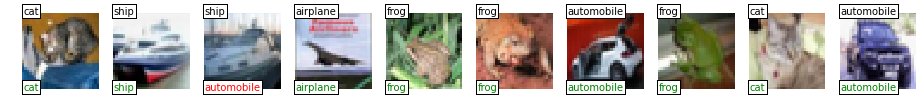

In [15]:
def make_image(X):
    im = np.swapaxes(X.T, 0, 1)
    im = im - im.min()
    im = im * 1.0 / im.max()
    return im

plt.figure(figsize=(16, 5))
for i in range(0, 10):
    plt.subplot(1, 10, i+1)
    plt.imshow(make_image(data['raw'][i]), interpolation='nearest')
    true = data['CLASSES'][data['labels'][i]]
    pred = data['CLASSES'][predicted[i]]
    color = 'green' if true == pred else 'red'
    plt.text(0, 0, true, color='black', bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 32, pred, color=color, bbox=dict(facecolor='white', alpha=1))

    plt.axis('off')

### Save our model
Let's save the weights in pickle format, so we don't need Caffe next time

In [16]:
import pickle

values = lasagne.layers.get_all_param_values(net['output'])
pickle.dump(values, open('model.pkl', 'w'))